In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=1

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200606, 2) (50134, 2)
train/valid # (200606, 2) (50134, 2)
rand split across time
train has 200606 records out of 389630 records
valid has 50134 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1567
0
(200606, 1, 32) (200606, 7, 32) (200606, 1) (200606, 1)
(200606, 256) (200606,) (200606,)
(50134, 1, 32) (50134, 7, 32) (50134, 1) (50134, 1)
(50134, 256) (50134,) (50134,)
(5803, 1, 32) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 256) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40152	valid-rmse:2.36304
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986281	valid-rmse:0.97981
[100]	train-rmse:0.574197	valid-rmse:0.588083
[150]	train-rmse:0.489613	valid-rmse:0.514049
[200]	train-rmse:0.473267	valid-rmse:0.503426
[250]	train-rmse:0.467827	valid-rmse:0.502038
[300]	train-rmse:0.464107	valid-rmse:0.501943
[350]	train-rmse:0.461369	valid-rmse:0.501935
Stopping. Best iteration:
[336]	train-rmse:0.462361	valid-rmse:0.501922

0.21377791 0.2519255
[0.2519255]
-1 mean score 0.2519255
0.192521348596


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924629  0.004481  0.201479    7  2017-04-16
472     2.507290  2.534830 -0.027539  0.209140    1  2017-04-17
473     2.661330  2.662374 -0.001044  0.224040    2  2017-04-18
474     2.754815  2.743587  0.011228  0.186448    3  2017-04-19
475     2.713762  2.709080  0.004682  0.216913    4  2017-04-20
476     2.999000  2.984678  0.014322  0.143522    5  2017-04-21
477     3.075529  3.077803 -0.002274  0.166107    6  2017-04-22

0.192521348596


pred         y     error    error2  day        date
dayidx                                                         
471     2.924629  2.929110  0.004481  0.201479    7  2017-04-16
472     2.534830  2.507290 -0.027539  0.209140    1  2017-04-17
473     2.662374  2.661330 -0.001044  0.224040    2  2017-04-18
474     2.743587  2.754815  0.011228  0.186448    3  2017-04-19
475     2.709080  2.713762  0.004682  0.216913    4  2017-04-20
476     2.984678  2.999000  0.014322  0.143522    5  2017-04-21
477     3.077803  3.075529 -0.002274  0.166107    6  2017-04-22

(829, 256)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200381, 2) (50076, 2)
train/valid # (200381, 2) (50076, 2)
rand split across time
train has 200381 records out of 389630 records
valid has 50076 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1565
0
(200381, 1, 32) (200381, 7, 32) (200381, 1) (200381, 1)
(200381, 256) (200381,) (200381,)
(50076, 1, 32) (50076, 7, 32) (50076, 1) (50076, 1)
(50076, 256) (50076,) (50076,)
(6632, 1, 32) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 256) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40139	valid-rmse:2.36274
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990018	valid-rmse:0.982815
[100]	train-rmse:0.579996	valid-rmse:0.593492
[150]	train-rmse:0.495088	valid-rmse:0.519748
[200]	train-rmse:0.478289	valid-rmse:0.508838
[250]	train-rmse:0.472319	valid-rmse:0.507274
[300]	train-rmse:0.468157	valid-rmse:0.506965
[350]	train-rmse:0.464965	valid-rmse:0.506891
Stopping. Best iteration:
[325]	train-rmse:0.466386	valid-rmse:0.506867

0.21751612 0.25691444
[0.25691444]
-1 mean score 0.25691444
0.195848360658


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914246  0.014864  0.209549    7  2017-04-16
472     2.507290  2.541692 -0.034402  0.216113    1  2017-04-17
473     2.661330  2.663654 -0.002324  0.223343    2  2017-04-18
474     2.754815  2.735180  0.019635  0.188923    3  2017-04-19
475     2.713762  2.716365 -0.002603  0.220894    4  2017-04-20
476     2.999000  2.987351  0.011649  0.144132    5  2017-04-21
477     3.075529  3.071123  0.004406  0.167984    6  2017-04-22

0.195848360658


pred         y     error    error2  day        date
dayidx                                                         
471     2.914246  2.929110  0.014864  0.209549    7  2017-04-16
472     2.541692  2.507290 -0.034402  0.216113    1  2017-04-17
473     2.663654  2.661330 -0.002324  0.223343    2  2017-04-18
474     2.735180  2.754815  0.019635  0.188923    3  2017-04-19
475     2.716365  2.713762 -0.002603  0.220894    4  2017-04-20
476     2.987351  2.999000  0.011649  0.144132    5  2017-04-21
477     3.071123  3.075529  0.004406  0.167984    6  2017-04-22

(829, 256)


3
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200200, 2) (50030, 2)
train/valid # (200200, 2) (50030, 2)
rand split across time
train has 200200 records out of 389630 records
valid has 50030 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1564
0
(200200, 1, 32) (200200, 7, 32) (200200, 1) (200200, 1)
(200200, 256) (200200,) (200200,)
(50030, 1, 32) (50030, 7, 32) (50030, 1) (50030, 1)
(50030, 256) (50030,) (50030,)
(7461, 1, 32) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 256) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4012	valid-rmse:2.3625
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991015	valid-rmse:0.983782
[100]	train-rmse:0.582152	valid-rmse:0.594913
[150]	train-rmse:0.497451	valid-rmse:0.521009
[200]	train-rmse:0.480525	valid-rmse:0.509949
[250]	train-rmse:0.474125	valid-rmse:0.508293
[300]	train-rmse:0.470165	valid-rmse:0.507875
[350]	train-rmse:0.466891	valid-rmse:0.507814
Stopping. Best iteration:
[331]	train-rmse:0.468145	valid-rmse:0.507781

0.21915953 0.25784168
[0.25784168]
-1 mean score 0.25784168
0.199859634042


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899435  0.029675  0.210045    7  2017-04-16
472     2.507290  2.531489 -0.024198  0.214494    1  2017-04-17
473     2.661330  2.646352  0.014978  0.240751    2  2017-04-18
474     2.754815  2.750317  0.004498  0.198393    3  2017-04-19
475     2.713762  2.712283  0.001478  0.220682    4  2017-04-20
476     2.999000  2.987068  0.011931  0.146415    5  2017-04-21
477     3.075529  3.067705  0.007824  0.168237    6  2017-04-22

0.199859634042


pred         y     error    error2  day        date
dayidx                                                         
471     2.899435  2.929110  0.029675  0.210045    7  2017-04-16
472     2.531489  2.507290 -0.024198  0.214494    1  2017-04-17
473     2.646352  2.661330  0.014978  0.240751    2  2017-04-18
474     2.750317  2.754815  0.004498  0.198393    3  2017-04-19
475     2.712283  2.713762  0.001478  0.220682    4  2017-04-20
476     2.987068  2.999000  0.011931  0.146415    5  2017-04-21
477     3.067705  3.075529  0.007824  0.168237    6  2017-04-22

(829, 256)


4
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200042, 2) (49986, 2)
train/valid # (200042, 2) (49986, 2)
rand split across time
train has 200042 records out of 389630 records
valid has 49986 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1562
0
(200042, 1, 32) (200042, 7, 32) (200042, 1) (200042, 1)
(200042, 256) (200042,) (200042,)
(49986, 1, 32) (49986, 7, 32) (49986, 1) (49986, 1)
(49986, 256) (49986,) (49986,)
(8290, 1, 32) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 256) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40122	valid-rmse:2.36243
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992117	valid-rmse:0.984307
[100]	train-rmse:0.583709	valid-rmse:0.596235
[150]	train-rmse:0.499171	valid-rmse:0.522766
[200]	train-rmse:0.482177	valid-rmse:0.511854
[250]	train-rmse:0.475681	valid-rmse:0.510134
[300]	train-rmse:0.471853	valid-rmse:0.509766
[350]	train-rmse:0.468851	valid-rmse:0.509593
[400]	train-rmse:0.465721	valid-rmse:0.509557
[450]	train-rmse:0.462737	valid-rmse:0.509561
Stopping. Best iteration:
[416]	train-rmse:0.464773	valid-rmse:0.509547

0.21601409 0.25963858
[0.25963858]
-1 mean score 0.25963858
0.195870742202


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906039  0.023071  0.209924    7  2017-04-16
472     2.507290  2.526229 -0.018939  0.214885    1  2017-04-17
473     2.661330  2.644546  0.016783  0.231396    2  2017-04-18
474     2.754815  2.735804  0.019011  0.191271    3  2017-04-19
475     2.713762  2.713681  0.000080  0.218559    4  2017-04-20
476     2.999000  2.979552  0.019448  0.142365    5  2017-04-21
477     3.075529  3.070033  0.005497  0.162697    6  2017-04-22

0.195870742202


pred         y     error    error2  day        date
dayidx                                                         
471     2.906039  2.929110  0.023071  0.209924    7  2017-04-16
472     2.526229  2.507290 -0.018939  0.214885    1  2017-04-17
473     2.644546  2.661330  0.016783  0.231396    2  2017-04-18
474     2.735804  2.754815  0.019011  0.191271    3  2017-04-19
475     2.713681  2.713762  0.000080  0.218559    4  2017-04-20
476     2.979552  2.999000  0.019448  0.142365    5  2017-04-21
477     3.070033  3.075529  0.005497  0.162697    6  2017-04-22

(829, 256)


5
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199839, 2) (49937, 2)
train/valid # (199839, 2) (49937, 2)
rand split across time
train has 199839 records out of 389630 records
valid has 49937 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1561
0
(199839, 1, 32) (199839, 7, 32) (199839, 1) (199839, 1)
(199839, 256) (199839,) (199839,)
(49937, 1, 32) (49937, 7, 32) (49937, 1) (49937, 1)
(49937, 256) (49937,) (49937,)
(9119, 1, 32) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 256) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40143	valid-rmse:2.36278
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993169	valid-rmse:0.986201
[100]	train-rmse:0.585132	valid-rmse:0.598697
[150]	train-rmse:0.500407	valid-rmse:0.524859
[200]	train-rmse:0.483423	valid-rmse:0.513773
[250]	train-rmse:0.477198	valid-rmse:0.511916
[300]	train-rmse:0.472755	valid-rmse:0.511529
[350]	train-rmse:0.46893	valid-rmse:0.511439
[400]	train-rmse:0.465656	valid-rmse:0.511454
Stopping. Best iteration:
[362]	train-rmse:0.468086	valid-rmse:0.511395

0.21910408 0.2615248
[0.2615248]
-1 mean score 0.2615248
0.199207738042


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901913  0.027197  0.211487    7  2017-04-16
472     2.507290  2.532393 -0.025102  0.219178    1  2017-04-17
473     2.661330  2.631035  0.030295  0.237191    2  2017-04-18
474     2.754815  2.734500  0.020315  0.193853    3  2017-04-19
475     2.713762  2.706741  0.007021  0.220543    4  2017-04-20
476     2.999000  2.977035  0.021965  0.147353    5  2017-04-21
477     3.075529  3.068733  0.006796  0.164850    6  2017-04-22

0.199207738042


pred         y     error    error2  day        date
dayidx                                                         
471     2.901913  2.929110  0.027197  0.211487    7  2017-04-16
472     2.532393  2.507290 -0.025102  0.219178    1  2017-04-17
473     2.631035  2.661330  0.030295  0.237191    2  2017-04-18
474     2.734500  2.754815  0.020315  0.193853    3  2017-04-19
475     2.706741  2.713762  0.007021  0.220543    4  2017-04-20
476     2.977035  2.999000  0.021965  0.147353    5  2017-04-21
477     3.068733  3.075529  0.006796  0.164850    6  2017-04-22

(829, 256)


6
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 15.133374
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199631, 2) (49882, 2)
train/valid # (199631, 2) (49882, 2)
rand split across time
train has 199631 records out of 389630 records
valid has 49882 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1559
0
(199631, 1, 32) (199631, 7, 32) (199631, 1) (199631, 1)
(199631, 256) (199631,) (199631,)
(49882, 1, 32) (49882, 7, 32) (49882, 1) (49882, 1)
(49882, 256) (49882,) (49882,)
(9948, 1, 32) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 256) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40162	valid-rmse:2.36298
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993389	valid-rmse:0.988106
[100]	train-rmse:0.585328	valid-rmse:0.600593
[150]	train-rmse:0.500687	valid-rmse:0.526641
[200]	train-rmse:0.483771	valid-rmse:0.515296
[250]	train-rmse:0.477397	valid-rmse:0.513451
[300]	train-rmse:0.473517	valid-rmse:0.513179
[350]	train-rmse:0.46968	valid-rmse:0.51317
Stopping. Best iteration:
[334]	train-rmse:0.470842	valid-rmse:0.513148

0.22169265 0.26332062
[0.26332062]
-1 mean score 0.26332062
0.204015851021


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913560  0.015550  0.219642    7  2017-04-16
472     2.507290  2.546423 -0.039133  0.230862    1  2017-04-17
473     2.661330  2.639873  0.021457  0.240355    2  2017-04-18
474     2.754815  2.732969  0.021846  0.196332    3  2017-04-19
475     2.713762  2.716210 -0.002449  0.224973    4  2017-04-20
476     2.999000  2.970257  0.028743  0.148861    5  2017-04-21
477     3.075529  3.079307 -0.003778  0.167086    6  2017-04-22

0.204015851021


pred         y     error    error2  day        date
dayidx                                                         
471     2.913560  2.929110  0.015550  0.219642    7  2017-04-16
472     2.546423  2.507290 -0.039133  0.230862    1  2017-04-17
473     2.639873  2.661330  0.021457  0.240355    2  2017-04-18
474     2.732969  2.754815  0.021846  0.196332    3  2017-04-19
475     2.716210  2.713762 -0.002449  0.224973    4  2017-04-20
476     2.970257  2.999000  0.028743  0.148861    5  2017-04-21
477     3.079307  3.075529 -0.003778  0.167086    6  2017-04-22

(829, 256)


7
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 16.310143
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199412, 2) (49827, 2)
train/valid # (199412, 2) (49827, 2)
rand split across time
train has 199412 records out of 389630 records
valid has 49827 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1557
0
(199412, 1, 32) (199412, 7, 32) (199412, 1) (199412, 1)
(199412, 256) (199412,) (199412,)
(49827, 1, 32) (49827, 7, 32) (49827, 1) (49827, 1)
(49827, 256) (49827,) (49827,)
(10777, 1, 32) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 256) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40171	valid-rmse:2.36316
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994429	valid-rmse:0.988717
[100]	train-rmse:0.58724	valid-rmse:0.601882
[150]	train-rmse:0.50319	valid-rmse:0.528442
[200]	train-rmse:0.486494	valid-rmse:0.517494
[250]	train-rmse:0.480698	valid-rmse:0.515798
[300]	train-rmse:0.476607	valid-rmse:0.515475
[350]	train-rmse:0.47355	valid-rmse:0.515409
[400]	train-rmse:0.470281	valid-rmse:0.515403
Stopping. Best iteration:
[382]	train-rmse:0.471426	valid-rmse:0.515385

0.22224234 0.26562166
[0.26562166]
-1 mean score 0.26562166
0.205070033669


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915663  0.013447  0.214654    7  2017-04-16
472     2.507290  2.555805 -0.048515  0.231880    1  2017-04-17
473     2.661330  2.643698  0.017632  0.239962    2  2017-04-18
474     2.754815  2.732697  0.022118  0.198692    3  2017-04-19
475     2.713762  2.708675  0.005087  0.228646    4  2017-04-20
476     2.999000  2.977933  0.021067  0.146555    5  2017-04-21
477     3.075529  3.096396 -0.020867  0.175100    6  2017-04-22

0.205070033669


pred         y     error    error2  day        date
dayidx                                                         
471     2.915663  2.929110  0.013447  0.214654    7  2017-04-16
472     2.555805  2.507290 -0.048515  0.231880    1  2017-04-17
473     2.643698  2.661330  0.017632  0.239962    2  2017-04-18
474     2.732697  2.754815  0.022118  0.198692    3  2017-04-19
475     2.708675  2.713762  0.005087  0.228646    4  2017-04-20
476     2.977933  2.999000  0.021067  0.146555    5  2017-04-21
477     3.096396  3.075529 -0.020867  0.175100    6  2017-04-22

(829, 256)


8
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 17.574337
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199179, 2) (49770, 2)
train/valid # (199179, 2) (49770, 2)
rand split across time
train has 199179 records out of 389630 records
valid has 49770 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1556
0
(199179, 1, 32) (199179, 7, 32) (199179, 1) (199179, 1)
(199179, 256) (199179,) (199179,)
(49770, 1, 32) (49770, 7, 32) (49770, 1) (49770, 1)
(49770, 256) (49770,) (49770,)
(11606, 1, 32) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 256) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40163	valid-rmse:2.36301
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995213	valid-rmse:0.989958
[100]	train-rmse:0.58949	valid-rmse:0.604932
[150]	train-rmse:0.506131	valid-rmse:0.5324
[200]	train-rmse:0.489164	valid-rmse:0.521437
[250]	train-rmse:0.48316	valid-rmse:0.519823
[300]	train-rmse:0.478744	valid-rmse:0.519521
[350]	train-rmse:0.475852	valid-rmse:0.519475
[400]	train-rmse:0.47267	valid-rmse:0.519445
Stopping. Best iteration:
[392]	train-rmse:0.473155	valid-rmse:0.519437

0.22387563 0.26981497
[0.26981497]
-1 mean score 0.26981497
0.208294436336


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.931200 -0.002090  0.229762    7  2017-04-16
472     2.507290  2.552788 -0.045498  0.227281    1  2017-04-17
473     2.661330  2.646957  0.014373  0.238980    2  2017-04-18
474     2.754815  2.737204  0.017611  0.206099    3  2017-04-19
475     2.713762  2.711803  0.001959  0.229180    4  2017-04-20
476     2.999000  2.965571  0.033429  0.155469    5  2017-04-21
477     3.075529  3.086186 -0.010657  0.171290    6  2017-04-22

0.208294436336


pred         y     error    error2  day        date
dayidx                                                         
471     2.931200  2.929110 -0.002090  0.229762    7  2017-04-16
472     2.552788  2.507290 -0.045498  0.227281    1  2017-04-17
473     2.646957  2.661330  0.014373  0.238980    2  2017-04-18
474     2.737204  2.754815  0.017611  0.206099    3  2017-04-19
475     2.711803  2.713762  0.001959  0.229180    4  2017-04-20
476     2.965571  2.999000  0.033429  0.155469    5  2017-04-21
477     3.086186  3.075529 -0.010657  0.171290    6  2017-04-22

(829, 256)


9
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 18.806503
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198954, 2) (49713, 2)
train/valid # (198954, 2) (49713, 2)
rand split across time
train has 198954 records out of 389630 records
valid has 49713 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1554
0
(198954, 1, 32) (198954, 7, 32) (198954, 1) (198954, 1)
(198954, 256) (198954,) (198954,)
(49713, 1, 32) (49713, 7, 32) (49713, 1) (49713, 1)
(49713, 256) (49713,) (49713,)
(12435, 1, 32) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 256) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40133	valid-rmse:2.36263
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996392	valid-rmse:0.990245
[100]	train-rmse:0.591612	valid-rmse:0.606527
[150]	train-rmse:0.508462	valid-rmse:0.534289
[200]	train-rmse:0.491634	valid-rmse:0.523498
[250]	train-rmse:0.485541	valid-rmse:0.521939
[300]	train-rmse:0.480769	valid-rmse:0.521573
[350]	train-rmse:0.47715	valid-rmse:0.521536
Stopping. Best iteration:
[329]	train-rmse:0.478637	valid-rmse:0.521509

0.22909302 0.27197123
[0.27197123]
-1 mean score 0.27197123
0.210220262408


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918172  0.010938  0.229723    7  2017-04-16
472     2.507290  2.562230 -0.054940  0.229537    1  2017-04-17
473     2.661330  2.659428  0.001902  0.241514    2  2017-04-18
474     2.754815  2.728868  0.025947  0.207586    3  2017-04-19
475     2.713762  2.716460 -0.002698  0.231593    4  2017-04-20
476     2.999000  2.965199  0.033801  0.158655    5  2017-04-21
477     3.075529  3.079290 -0.003760  0.172934    6  2017-04-22

0.210220262408


pred         y     error    error2  day        date
dayidx                                                         
471     2.918172  2.929110  0.010938  0.229723    7  2017-04-16
472     2.562230  2.507290 -0.054940  0.229537    1  2017-04-17
473     2.659428  2.661330  0.001902  0.241514    2  2017-04-18
474     2.728868  2.754815  0.025947  0.207586    3  2017-04-19
475     2.716460  2.713762 -0.002698  0.231593    4  2017-04-20
476     2.965199  2.999000  0.033801  0.158655    5  2017-04-21
477     3.079290  3.075529 -0.003760  0.172934    6  2017-04-22

(829, 256)


10
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 19.926521
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198785, 2) (49666, 2)
train/valid # (198785, 2) (49666, 2)
rand split across time
train has 198785 records out of 389630 records
valid has 49666 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1553
0
(198785, 1, 32) (198785, 7, 32) (198785, 1) (198785, 1)
(198785, 256) (198785,) (198785,)
(49666, 1, 32) (49666, 7, 32) (49666, 1) (49666, 1)
(49666, 256) (49666,) (49666,)
(13264, 1, 32) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 256) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40132	valid-rmse:2.3625
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997217	valid-rmse:0.990359
[100]	train-rmse:0.593179	valid-rmse:0.606795
[150]	train-rmse:0.510161	valid-rmse:0.534633
[200]	train-rmse:0.493338	valid-rmse:0.523807
[250]	train-rmse:0.48675	valid-rmse:0.522033
[300]	train-rmse:0.481938	valid-rmse:0.521681
[350]	train-rmse:0.478268	valid-rmse:0.521572
Stopping. Best iteration:
[342]	train-rmse:0.478813	valid-rmse:0.521554

0.22926228 0.2720188
[0.2720188]
-1 mean score 0.2720188
0.209925338626


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915344  0.013766  0.225213    7  2017-04-16
472     2.507290  2.545192 -0.037901  0.227378    1  2017-04-17
473     2.661330  2.660663  0.000667  0.251156    2  2017-04-18
474     2.754815  2.737837  0.016978  0.206302    3  2017-04-19
475     2.713762  2.719951 -0.006190  0.229271    4  2017-04-20
476     2.999000  2.967999  0.031001  0.159743    5  2017-04-21
477     3.075529  3.081373 -0.005844  0.170415    6  2017-04-22

0.209925338626


pred         y     error    error2  day        date
dayidx                                                         
471     2.915344  2.929110  0.013766  0.225213    7  2017-04-16
472     2.545192  2.507290 -0.037901  0.227378    1  2017-04-17
473     2.660663  2.661330  0.000667  0.251156    2  2017-04-18
474     2.737837  2.754815  0.016978  0.206302    3  2017-04-19
475     2.719951  2.713762 -0.006190  0.229271    4  2017-04-20
476     2.967999  2.999000  0.031001  0.159743    5  2017-04-21
477     3.081373  3.075529 -0.005844  0.170415    6  2017-04-22

(829, 256)


11
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 21.05768
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198605, 2) (49620, 2)
train/valid # (198605, 2) (49620, 2)
rand split across time
train has 198605 records out of 389630 records
valid has 49620 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1551
0
(198605, 1, 32) (198605, 7, 32) (198605, 1) (198605, 1)
(198605, 256) (198605,) (198605,)
(49620, 1, 32) (49620, 7, 32) (49620, 1) (49620, 1)
(49620, 256) (49620,) (49620,)
(14093, 1, 32) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 256) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40164	valid-rmse:2.36287
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997819	valid-rmse:0.991681
[100]	train-rmse:0.593773	valid-rmse:0.608074
[150]	train-rmse:0.510704	valid-rmse:0.535907
[200]	train-rmse:0.493764	valid-rmse:0.52499
[250]	train-rmse:0.487092	valid-rmse:0.523147
[300]	train-rmse:0.482207	valid-rmse:0.522718
[350]	train-rmse:0.478386	valid-rmse:0.522662
[400]	train-rmse:0.474806	valid-rmse:0.522658
Stopping. Best iteration:
[371]	train-rmse:0.476928	valid-rmse:0.522623

0.22745985 0.2731349
[0.2731349]
-1 mean score 0.2731349
0.20894305408


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908751  0.020358  0.221993    7  2017-04-16
472     2.507290  2.550392 -0.043102  0.226619    1  2017-04-17
473     2.661330  2.661222  0.000107  0.252684    2  2017-04-18
474     2.754815  2.733379  0.021436  0.203727    3  2017-04-19
475     2.713762  2.735135 -0.021373  0.226412    4  2017-04-20
476     2.999000  2.975686  0.023313  0.159685    5  2017-04-21
477     3.075529  3.069980  0.005549  0.171481    6  2017-04-22

0.20894305408


pred         y     error    error2  day        date
dayidx                                                         
471     2.908751  2.929110  0.020358  0.221993    7  2017-04-16
472     2.550392  2.507290 -0.043102  0.226619    1  2017-04-17
473     2.661222  2.661330  0.000107  0.252684    2  2017-04-18
474     2.733379  2.754815  0.021436  0.203727    3  2017-04-19
475     2.735135  2.713762 -0.021373  0.226412    4  2017-04-20
476     2.975686  2.999000  0.023313  0.159685    5  2017-04-21
477     3.069980  3.075529  0.005549  0.171481    6  2017-04-22

(829, 256)


12
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 22.115147
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198392, 2) (49566, 2)
train/valid # (198392, 2) (49566, 2)
rand split across time
train has 198392 records out of 389630 records
valid has 49566 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1549
0
(198392, 1, 32) (198392, 7, 32) (198392, 1) (198392, 1)
(198392, 256) (198392,) (198392,)
(49566, 1, 32) (49566, 7, 32) (49566, 1) (49566, 1)
(49566, 256) (49566,) (49566,)
(14922, 1, 32) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 256) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40185	valid-rmse:2.36295
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99883	valid-rmse:0.992551
[100]	train-rmse:0.594891	valid-rmse:0.609645
[150]	train-rmse:0.511511	valid-rmse:0.537626
[200]	train-rmse:0.494035	valid-rmse:0.526777
[250]	train-rmse:0.487514	valid-rmse:0.52511
[300]	train-rmse:0.483088	valid-rmse:0.524761
[350]	train-rmse:0.479378	valid-rmse:0.524557
[400]	train-rmse:0.476019	valid-rmse:0.524482
[450]	train-rmse:0.472965	valid-rmse:0.524512
Stopping. Best iteration:
[428]	train-rmse:0.474384	valid-rmse:0.524467

0.22503982 0.27506542
[0.27506542]
-1 mean score 0.27506542
0.20793132484


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905771  0.023340  0.225780    7  2017-04-16
472     2.507290  2.549191 -0.041900  0.221343    1  2017-04-17
473     2.661330  2.662978 -0.001649  0.252246    2  2017-04-18
474     2.754815  2.729611  0.025204  0.208512    3  2017-04-19
475     2.713762  2.725231 -0.011469  0.223813    4  2017-04-20
476     2.999000  2.976292  0.022708  0.155519    5  2017-04-21
477     3.075529  3.076937 -0.001408  0.168307    6  2017-04-22

0.20793132484


pred         y     error    error2  day        date
dayidx                                                         
471     2.905771  2.929110  0.023340  0.225780    7  2017-04-16
472     2.549191  2.507290 -0.041900  0.221343    1  2017-04-17
473     2.662978  2.661330 -0.001649  0.252246    2  2017-04-18
474     2.729611  2.754815  0.025204  0.208512    3  2017-04-19
475     2.725231  2.713762 -0.011469  0.223813    4  2017-04-20
476     2.976292  2.999000  0.022708  0.155519    5  2017-04-21
477     3.076937  3.075529 -0.001408  0.168307    6  2017-04-22

(829, 256)


13
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 23.15517
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198182, 2) (49513, 2)
train/valid # (198182, 2) (49513, 2)
rand split across time
train has 198182 records out of 389630 records
valid has 49513 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1548
0
(198182, 1, 32) (198182, 7, 32) (198182, 1) (198182, 1)
(198182, 256) (198182,) (198182,)
(49513, 1, 32) (49513, 7, 32) (49513, 1) (49513, 1)
(49513, 256) (49513,) (49513,)
(15751, 1, 32) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 256) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40194	valid-rmse:2.36318
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998859	valid-rmse:0.993777
[100]	train-rmse:0.595157	valid-rmse:0.610907
[150]	train-rmse:0.511757	valid-rmse:0.538348
[200]	train-rmse:0.494617	valid-rmse:0.527228
[250]	train-rmse:0.488196	valid-rmse:0.525405
[300]	train-rmse:0.48401	valid-rmse:0.525037
[350]	train-rmse:0.480431	valid-rmse:0.525003
[400]	train-rmse:0.477194	valid-rmse:0.525015
Stopping. Best iteration:
[360]	train-rmse:0.479713	valid-rmse:0.524981

0.23012486 0.2756055
[0.2756055]
-1 mean score 0.2756055
0.210956558585


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904689  0.024421  0.227162    7  2017-04-16
472     2.507290  2.550580 -0.043289  0.230408    1  2017-04-17
473     2.661330  2.666255 -0.004925  0.251257    2  2017-04-18
474     2.754815  2.734585  0.020229  0.213416    3  2017-04-19
475     2.713762  2.726675 -0.012913  0.228949    4  2017-04-20
476     2.999000  2.980543  0.018457  0.155607    5  2017-04-21
477     3.075529  3.068220  0.007309  0.169896    6  2017-04-22

0.210956558585


pred         y     error    error2  day        date
dayidx                                                         
471     2.904689  2.929110  0.024421  0.227162    7  2017-04-16
472     2.550580  2.507290 -0.043289  0.230408    1  2017-04-17
473     2.666255  2.661330 -0.004925  0.251257    2  2017-04-18
474     2.734585  2.754815  0.020229  0.213416    3  2017-04-19
475     2.726675  2.713762 -0.012913  0.228949    4  2017-04-20
476     2.980543  2.999000  0.018457  0.155607    5  2017-04-21
477     3.068220  3.075529  0.007309  0.169896    6  2017-04-22

(829, 256)


14
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 24.22639
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197959, 2) (49458, 2)
train/valid # (197959, 2) (49458, 2)
rand split across time
train has 197959 records out of 389630 records
valid has 49458 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1546
0
(197959, 1, 32) (197959, 7, 32) (197959, 1) (197959, 1)
(197959, 256) (197959,) (197959,)
(49458, 1, 32) (49458, 7, 32) (49458, 1) (49458, 1)
(49458, 256) (49458,) (49458,)
(16580, 1, 32) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 256) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.402	valid-rmse:2.36326
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999307	valid-rmse:0.993278
[100]	train-rmse:0.596057	valid-rmse:0.610449
[150]	train-rmse:0.513057	valid-rmse:0.538452
[200]	train-rmse:0.496292	valid-rmse:0.527735
[250]	train-rmse:0.489973	valid-rmse:0.526081
[300]	train-rmse:0.485242	valid-rmse:0.525682
[350]	train-rmse:0.481663	valid-rmse:0.525588
[400]	train-rmse:0.477938	valid-rmse:0.525584
[450]	train-rmse:0.474615	valid-rmse:0.525581
Stopping. Best iteration:
[427]	train-rmse:0.476122	valid-rmse:0.52554

0.22669175 0.27619207
[0.27619207]
-1 mean score 0.27619207
0.20885322988


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902124  0.026986  0.226048    7  2017-04-16
472     2.507290  2.542219 -0.034929  0.224868    1  2017-04-17
473     2.661330  2.660938  0.000391  0.250706    2  2017-04-18
474     2.754815  2.727544  0.027271  0.214138    3  2017-04-19
475     2.713762  2.725359 -0.011597  0.224809    4  2017-04-20
476     2.999000  2.988636  0.010364  0.150548    5  2017-04-21
477     3.075529  3.082553 -0.007023  0.170855    6  2017-04-22

0.20885322988


pred         y     error    error2  day        date
dayidx                                                         
471     2.902124  2.929110  0.026986  0.226048    7  2017-04-16
472     2.542219  2.507290 -0.034929  0.224868    1  2017-04-17
473     2.660938  2.661330  0.000391  0.250706    2  2017-04-18
474     2.727544  2.754815  0.027271  0.214138    3  2017-04-19
475     2.725359  2.713762 -0.011597  0.224809    4  2017-04-20
476     2.988636  2.999000  0.010364  0.150548    5  2017-04-21
477     3.082553  3.075529 -0.007023  0.170855    6  2017-04-22

(829, 256)


15
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 25.357664
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197725, 2) (49402, 2)
train/valid # (197725, 2) (49402, 2)
rand split across time
train has 197725 records out of 389630 records
valid has 49402 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1544
0
(197725, 1, 32) (197725, 7, 32) (197725, 1) (197725, 1)
(197725, 256) (197725,) (197725,)
(49402, 1, 32) (49402, 7, 32) (49402, 1) (49402, 1)
(49402, 256) (49402,) (49402,)
(17409, 1, 32) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 256) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40193	valid-rmse:2.36305
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999726	valid-rmse:0.992124
[100]	train-rmse:0.597774	valid-rmse:0.611027
[150]	train-rmse:0.515372	valid-rmse:0.540283
[200]	train-rmse:0.498626	valid-rmse:0.530025
[250]	train-rmse:0.492187	valid-rmse:0.528594
[300]	train-rmse:0.487804	valid-rmse:0.528393
Stopping. Best iteration:
[294]	train-rmse:0.48822	valid-rmse:0.528387

0.23835862 0.27919242
[0.27919242]
-1 mean score 0.27919242
0.218809023499


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912599  0.016511  0.240333    7  2017-04-16
472     2.507290  2.544720 -0.037429  0.237120    1  2017-04-17
473     2.661330  2.650101  0.011229  0.263323    2  2017-04-18
474     2.754815  2.723593  0.031221  0.217910    3  2017-04-19
475     2.713762  2.722382 -0.008620  0.234342    4  2017-04-20
476     2.999000  2.985353  0.013647  0.160614    5  2017-04-21
477     3.075529  3.069400  0.006129  0.178021    6  2017-04-22

0.218809023499


pred         y     error    error2  day        date
dayidx                                                         
471     2.912599  2.929110  0.016511  0.240333    7  2017-04-16
472     2.544720  2.507290 -0.037429  0.237120    1  2017-04-17
473     2.650101  2.661330  0.011229  0.263323    2  2017-04-18
474     2.723593  2.754815  0.031221  0.217910    3  2017-04-19
475     2.722382  2.713762 -0.008620  0.234342    4  2017-04-20
476     2.985353  2.999000  0.013647  0.160614    5  2017-04-21
477     3.069400  3.075529  0.006129  0.178021    6  2017-04-22

(829, 256)


16
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 26.465925
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197493, 2) (49345, 2)
train/valid # (197493, 2) (49345, 2)
rand split across time
train has 197493 records out of 389630 records
valid has 49345 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1542
0
(197493, 1, 32) (197493, 7, 32) (197493, 1) (197493, 1)
(197493, 256) (197493,) (197493,)
(49345, 1, 32) (49345, 7, 32) (49345, 1) (49345, 1)
(49345, 256) (49345,) (49345,)
(18238, 1, 32) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 256) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40168	valid-rmse:2.36275
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00083	valid-rmse:0.992785
[100]	train-rmse:0.599725	valid-rmse:0.613104
[150]	train-rmse:0.517879	valid-rmse:0.543121
[200]	train-rmse:0.50096	valid-rmse:0.532941
[250]	train-rmse:0.49436	valid-rmse:0.531537
[300]	train-rmse:0.489329	valid-rmse:0.531215
[350]	train-rmse:0.485839	valid-rmse:0.53118
Stopping. Best iteration:
[342]	train-rmse:0.486478	valid-rmse:0.531164

0.23666109 0.28213483
[0.28213483]
-1 mean score 0.28213483
0.216162204742


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905132  0.023978  0.235635    7  2017-04-16
472     2.507290  2.554965 -0.047674  0.233687    1  2017-04-17
473     2.661330  2.652546  0.008783  0.260510    2  2017-04-18
474     2.754815  2.715709  0.039106  0.211577    3  2017-04-19
475     2.713762  2.726639 -0.012878  0.236991    4  2017-04-20
476     2.999000  2.983333  0.015667  0.160222    5  2017-04-21
477     3.075529  3.066750  0.008779  0.174513    6  2017-04-22

0.216162204742


pred         y     error    error2  day        date
dayidx                                                         
471     2.905132  2.929110  0.023978  0.235635    7  2017-04-16
472     2.554965  2.507290 -0.047674  0.233687    1  2017-04-17
473     2.652546  2.661330  0.008783  0.260510    2  2017-04-18
474     2.715709  2.754815  0.039106  0.211577    3  2017-04-19
475     2.726639  2.713762 -0.012878  0.236991    4  2017-04-20
476     2.983333  2.999000  0.015667  0.160222    5  2017-04-21
477     3.066750  3.075529  0.008779  0.174513    6  2017-04-22

(829, 256)


17
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 27.605818
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197331, 2) (49305, 2)
train/valid # (197331, 2) (49305, 2)
rand split across time
train has 197331 records out of 389630 records
valid has 49305 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1541
0
(197331, 1, 32) (197331, 7, 32) (197331, 1) (197331, 1)
(197331, 256) (197331,) (197331,)
(49305, 1, 32) (49305, 7, 32) (49305, 1) (49305, 1)
(49305, 256) (49305,) (49305,)
(19067, 1, 32) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 256) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40172	valid-rmse:2.36277
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0013	valid-rmse:0.995636
[100]	train-rmse:0.600592	valid-rmse:0.615542
[150]	train-rmse:0.518676	valid-rmse:0.544313
[200]	train-rmse:0.501666	valid-rmse:0.533548
[250]	train-rmse:0.49436	valid-rmse:0.531754
[300]	train-rmse:0.489471	valid-rmse:0.531274
[350]	train-rmse:0.485398	valid-rmse:0.531184
Stopping. Best iteration:
[344]	train-rmse:0.485885	valid-rmse:0.531167

0.23608465 0.28213865
[0.28213865]
-1 mean score 0.28213865
0.217120781541


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908050  0.021060  0.231419    7  2017-04-16
472     2.507290  2.531871 -0.024581  0.229363    1  2017-04-17
473     2.661330  2.643593  0.017737  0.263560    2  2017-04-18
474     2.754815  2.718343  0.036472  0.218882    3  2017-04-19
475     2.713762  2.719983 -0.006222  0.234194    4  2017-04-20
476     2.999000  2.988093  0.010906  0.163168    5  2017-04-21
477     3.075529  3.059528  0.016001  0.179259    6  2017-04-22

0.217120781541


pred         y     error    error2  day        date
dayidx                                                         
471     2.908050  2.929110  0.021060  0.231419    7  2017-04-16
472     2.531871  2.507290 -0.024581  0.229363    1  2017-04-17
473     2.643593  2.661330  0.017737  0.263560    2  2017-04-18
474     2.718343  2.754815  0.036472  0.218882    3  2017-04-19
475     2.719983  2.713762 -0.006222  0.234194    4  2017-04-20
476     2.988093  2.999000  0.010906  0.163168    5  2017-04-21
477     3.059528  3.075529  0.016001  0.179259    6  2017-04-22

(829, 256)


18
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 28.75126
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197143, 2) (49257, 2)
train/valid # (197143, 2) (49257, 2)
rand split across time
train has 197143 records out of 389630 records
valid has 49257 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1540
0
(197143, 1, 32) (197143, 7, 32) (197143, 1) (197143, 1)
(197143, 256) (197143,) (197143,)
(49257, 1, 32) (49257, 7, 32) (49257, 1) (49257, 1)
(49257, 256) (49257,) (49257,)
(19896, 1, 32) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 256) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40194	valid-rmse:2.36312
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00226	valid-rmse:0.99775
[100]	train-rmse:0.601769	valid-rmse:0.61681
[150]	train-rmse:0.519882	valid-rmse:0.54507
[200]	train-rmse:0.503011	valid-rmse:0.534154
[250]	train-rmse:0.496043	valid-rmse:0.53229
[300]	train-rmse:0.491301	valid-rmse:0.53183
[350]	train-rmse:0.487528	valid-rmse:0.531765
[400]	train-rmse:0.484037	valid-rmse:0.531746
[450]	train-rmse:0.480563	valid-rmse:0.531748
Stopping. Best iteration:
[416]	train-rmse:0.482964	valid-rmse:0.5317

0.23325388 0.28270453
[0.28270453]
-1 mean score 0.28270453
0.214349657297


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908919  0.020191  0.233994    7  2017-04-16
472     2.507290  2.539425 -0.032134  0.228196    1  2017-04-17
473     2.661330  2.642439  0.018891  0.254874    2  2017-04-18
474     2.754815  2.715366  0.039449  0.209028    3  2017-04-19
475     2.713762  2.716851 -0.003090  0.236577    4  2017-04-20
476     2.999000  2.982757  0.016243  0.162290    5  2017-04-21
477     3.075529  3.058894  0.016635  0.175489    6  2017-04-22

0.214349657297


pred         y     error    error2  day        date
dayidx                                                         
471     2.908919  2.929110  0.020191  0.233994    7  2017-04-16
472     2.539425  2.507290 -0.032134  0.228196    1  2017-04-17
473     2.642439  2.661330  0.018891  0.254874    2  2017-04-18
474     2.715366  2.754815  0.039449  0.209028    3  2017-04-19
475     2.716851  2.713762 -0.003090  0.236577    4  2017-04-20
476     2.982757  2.999000  0.016243  0.162290    5  2017-04-21
477     3.058894  3.075529  0.016635  0.175489    6  2017-04-22

(829, 256)


19
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 29.798643
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196929, 2) (49206, 2)
train/valid # (196929, 2) (49206, 2)
rand split across time
train has 196929 records out of 389630 records
valid has 49206 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1538
0
(196929, 1, 32) (196929, 7, 32) (196929, 1) (196929, 1)
(196929, 256) (196929,) (196929,)
(49206, 1, 32) (49206, 7, 32) (49206, 1) (49206, 1)
(49206, 256) (49206,) (49206,)
(20725, 1, 32) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 256) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40206	valid-rmse:2.36321
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00276	valid-rmse:0.995847
[100]	train-rmse:0.602149	valid-rmse:0.615679
[150]	train-rmse:0.519689	valid-rmse:0.544938
[200]	train-rmse:0.50215	valid-rmse:0.534436
[250]	train-rmse:0.495335	valid-rmse:0.532736
[300]	train-rmse:0.491026	valid-rmse:0.532358
[350]	train-rmse:0.486731	valid-rmse:0.532159
[400]	train-rmse:0.482759	valid-rmse:0.532069
[450]	train-rmse:0.479125	valid-rmse:0.532098
Stopping. Best iteration:
[400]	train-rmse:0.482759	valid-rmse:0.532069

0.23305622 0.2830977
[0.2830977]
-1 mean score 0.2830977
0.215027049184


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912925  0.016185  0.232442    7  2017-04-16
472     2.507290  2.548342 -0.041051  0.231178    1  2017-04-17
473     2.661330  2.641237  0.020092  0.249347    2  2017-04-18
474     2.754815  2.717693  0.037122  0.213284    3  2017-04-19
475     2.713762  2.721346 -0.007585  0.234787    4  2017-04-20
476     2.999000  2.970247  0.028753  0.165338    5  2017-04-21
477     3.075529  3.061179  0.014351  0.178813    6  2017-04-22

0.215027049184


pred         y     error    error2  day        date
dayidx                                                         
471     2.912925  2.929110  0.016185  0.232442    7  2017-04-16
472     2.548342  2.507290 -0.041051  0.231178    1  2017-04-17
473     2.641237  2.661330  0.020092  0.249347    2  2017-04-18
474     2.717693  2.754815  0.037122  0.213284    3  2017-04-19
475     2.721346  2.713762 -0.007585  0.234787    4  2017-04-20
476     2.970247  2.999000  0.028753  0.165338    5  2017-04-21
477     3.061179  3.075529  0.014351  0.178813    6  2017-04-22

(829, 256)


20
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 30.796307
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196711, 2) (49150, 2)
train/valid # (196711, 2) (49150, 2)
rand split across time
train has 196711 records out of 389630 records
valid has 49150 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1536
0
(196711, 1, 32) (196711, 7, 32) (196711, 1) (196711, 1)
(196711, 256) (196711,) (196711,)
(49150, 1, 32) (49150, 7, 32) (49150, 1) (49150, 1)
(49150, 256) (49150,) (49150,)
(21554, 1, 32) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 256) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40212	valid-rmse:2.36333
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00311	valid-rmse:0.997358
[100]	train-rmse:0.602687	valid-rmse:0.617081
[150]	train-rmse:0.51998	valid-rmse:0.545407
[200]	train-rmse:0.502694	valid-rmse:0.534577
[250]	train-rmse:0.495459	valid-rmse:0.532857
[300]	train-rmse:0.491042	valid-rmse:0.532464
[350]	train-rmse:0.486968	valid-rmse:0.532334
[400]	train-rmse:0.483252	valid-rmse:0.532327
Stopping. Best iteration:
[398]	train-rmse:0.483317	valid-rmse:0.532322

0.23359522 0.2833668
[0.2833668]
-1 mean score 0.2833668
0.214434638619


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920954  0.008156  0.228465    7  2017-04-16
472     2.507290  2.556322 -0.049031  0.231771    1  2017-04-17
473     2.661330  2.645013  0.016317  0.252009    2  2017-04-18
474     2.754815  2.721964  0.032850  0.212767    3  2017-04-19
475     2.713762  2.717051 -0.003290  0.234783    4  2017-04-20
476     2.999000  2.966907  0.032093  0.163244    5  2017-04-21
477     3.075529  3.057882  0.017648  0.178004    6  2017-04-22

0.214434638619


pred         y     error    error2  day        date
dayidx                                                         
471     2.920954  2.929110  0.008156  0.228465    7  2017-04-16
472     2.556322  2.507290 -0.049031  0.231771    1  2017-04-17
473     2.645013  2.661330  0.016317  0.252009    2  2017-04-18
474     2.721964  2.754815  0.032850  0.212767    3  2017-04-19
475     2.717051  2.713762 -0.003290  0.234783    4  2017-04-20
476     2.966907  2.999000  0.032093  0.163244    5  2017-04-21
477     3.057882  3.075529  0.017648  0.178004    6  2017-04-22

(829, 256)


21
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 31.792852
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196485, 2) (49095, 2)
train/valid # (196485, 2) (49095, 2)
rand split across time
train has 196485 records out of 389630 records
valid has 49095 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1535
0
(196485, 1, 32) (196485, 7, 32) (196485, 1) (196485, 1)
(196485, 256) (196485,) (196485,)
(49095, 1, 32) (49095, 7, 32) (49095, 1) (49095, 1)
(49095, 256) (49095,) (49095,)
(22383, 1, 32) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 256) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4022	valid-rmse:2.36318
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00343	valid-rmse:0.994303
[100]	train-rmse:0.603372	valid-rmse:0.615256
[150]	train-rmse:0.521427	valid-rmse:0.545486
[200]	train-rmse:0.504371	valid-rmse:0.535426
[250]	train-rmse:0.497309	valid-rmse:0.533998
[300]	train-rmse:0.492466	valid-rmse:0.533837
[350]	train-rmse:0.488026	valid-rmse:0.533784
Stopping. Best iteration:
[345]	train-rmse:0.488424	valid-rmse:0.53378

0.23855819 0.28492087
[0.28492087]
-1 mean score 0.28492087
0.218818351626


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900187  0.028923  0.235532    7  2017-04-16
472     2.507290  2.549943 -0.042652  0.234671    1  2017-04-17
473     2.661330  2.649761  0.011569  0.257110    2  2017-04-18
474     2.754815  2.724368  0.030447  0.216856    3  2017-04-19
475     2.713762  2.699690  0.014071  0.237099    4  2017-04-20
476     2.999000  2.965171  0.033829  0.169203    5  2017-04-21
477     3.075529  3.066274  0.009255  0.181258    6  2017-04-22

0.218818351626


pred         y     error    error2  day        date
dayidx                                                         
471     2.900187  2.929110  0.028923  0.235532    7  2017-04-16
472     2.549943  2.507290 -0.042652  0.234671    1  2017-04-17
473     2.649761  2.661330  0.011569  0.257110    2  2017-04-18
474     2.724368  2.754815  0.030447  0.216856    3  2017-04-19
475     2.699690  2.713762  0.014071  0.237099    4  2017-04-20
476     2.965171  2.999000  0.033829  0.169203    5  2017-04-21
477     3.066274  3.075529  0.009255  0.181258    6  2017-04-22

(829, 256)


22
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 32.870983
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196255, 2) (49037, 2)
train/valid # (196255, 2) (49037, 2)
rand split across time
train has 196255 records out of 389630 records
valid has 49037 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1533
0
(196255, 1, 32) (196255, 7, 32) (196255, 1) (196255, 1)
(196255, 256) (196255,) (196255,)
(49037, 1, 32) (49037, 7, 32) (49037, 1) (49037, 1)
(49037, 256) (49037,) (49037,)
(23212, 1, 32) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 256) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40218	valid-rmse:2.36336
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00344	valid-rmse:0.997141
[100]	train-rmse:0.604231	valid-rmse:0.61848
[150]	train-rmse:0.52267	valid-rmse:0.548037
[200]	train-rmse:0.505586	valid-rmse:0.537586
[250]	train-rmse:0.499138	valid-rmse:0.536022
[300]	train-rmse:0.494261	valid-rmse:0.535815
[350]	train-rmse:0.490145	valid-rmse:0.535837
Stopping. Best iteration:
[325]	train-rmse:0.492188	valid-rmse:0.53581

0.2422495 0.28709185
[0.28709185]
-1 mean score 0.28709185
0.218458622694


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912647  0.016463  0.233215    7  2017-04-16
472     2.507290  2.529430 -0.022139  0.231879    1  2017-04-17
473     2.661330  2.645863  0.015467  0.254193    2  2017-04-18
474     2.754815  2.724539  0.030275  0.220833    3  2017-04-19
475     2.713762  2.708658  0.005104  0.244110    4  2017-04-20
476     2.999000  2.963687  0.035313  0.166535    5  2017-04-21
477     3.075529  3.058603  0.016926  0.178445    6  2017-04-22

0.218458622694


pred         y     error    error2  day        date
dayidx                                                         
471     2.912647  2.929110  0.016463  0.233215    7  2017-04-16
472     2.529430  2.507290 -0.022139  0.231879    1  2017-04-17
473     2.645863  2.661330  0.015467  0.254193    2  2017-04-18
474     2.724539  2.754815  0.030275  0.220833    3  2017-04-19
475     2.708658  2.713762  0.005104  0.244110    4  2017-04-20
476     2.963687  2.999000  0.035313  0.166535    5  2017-04-21
477     3.058603  3.075529  0.016926  0.178445    6  2017-04-22

(829, 256)


23
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 33.974537
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196025, 2) (48978, 2)
train/valid # (196025, 2) (48978, 2)
rand split across time
train has 196025 records out of 389630 records
valid has 48978 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1531
0
(196025, 1, 32) (196025, 7, 32) (196025, 1) (196025, 1)
(196025, 256) (196025,) (196025,)
(48978, 1, 32) (48978, 7, 32) (48978, 1) (48978, 1)
(48978, 256) (48978,) (48978,)
(24041, 1, 32) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 256) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40191	valid-rmse:2.36314
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00457	valid-rmse:0.99927
[100]	train-rmse:0.606233	valid-rmse:0.621174
[150]	train-rmse:0.525016	valid-rmse:0.550882
[200]	train-rmse:0.507724	valid-rmse:0.54032
[250]	train-rmse:0.501216	valid-rmse:0.538551
[300]	train-rmse:0.496255	valid-rmse:0.538326
[350]	train-rmse:0.492044	valid-rmse:0.538244
[400]	train-rmse:0.488431	valid-rmse:0.538241
[450]	train-rmse:0.48526	valid-rmse:0.538282
Stopping. Best iteration:
[409]	train-rmse:0.487902	valid-rmse:0.538229

0.23804823 0.28968996
[0.28968996]
-1 mean score 0.28968996
0.214057564735


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911987  0.017123  0.226283    7  2017-04-16
472     2.507290  2.541788 -0.034498  0.225681    1  2017-04-17
473     2.661330  2.656794  0.004536  0.245354    2  2017-04-18
474     2.754815  2.726313  0.028502  0.212424    3  2017-04-19
475     2.713762  2.716949 -0.003187  0.242120    4  2017-04-20
476     2.999000  2.967909  0.031091  0.170509    5  2017-04-21
477     3.075529  3.056041  0.019488  0.176033    6  2017-04-22

0.214057564735


pred         y     error    error2  day        date
dayidx                                                         
471     2.911987  2.929110  0.017123  0.226283    7  2017-04-16
472     2.541788  2.507290 -0.034498  0.225681    1  2017-04-17
473     2.656794  2.661330  0.004536  0.245354    2  2017-04-18
474     2.726313  2.754815  0.028502  0.212424    3  2017-04-19
475     2.716949  2.713762 -0.003187  0.242120    4  2017-04-20
476     2.967909  2.999000  0.031091  0.170509    5  2017-04-21
477     3.056041  3.075529  0.019488  0.176033    6  2017-04-22

(829, 256)


24
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 35.208443
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195855, 2) (48933, 2)
train/valid # (195855, 2) (48933, 2)
rand split across time
train has 195855 records out of 389630 records
valid has 48933 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1530
0
(195855, 1, 32) (195855, 7, 32) (195855, 1) (195855, 1)
(195855, 256) (195855,) (195855,)
(48933, 1, 32) (48933, 7, 32) (48933, 1) (48933, 1)
(48933, 256) (48933,) (48933,)
(24870, 1, 32) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 256) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40183	valid-rmse:2.3629
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00493	valid-rmse:0.99754
[100]	train-rmse:0.607095	valid-rmse:0.620455
[150]	train-rmse:0.525798	valid-rmse:0.550584
[200]	train-rmse:0.508714	valid-rmse:0.540288
[250]	train-rmse:0.50172	valid-rmse:0.538635
[300]	train-rmse:0.496987	valid-rmse:0.538272
[350]	train-rmse:0.493163	valid-rmse:0.538136
[400]	train-rmse:0.489521	valid-rmse:0.538137
Stopping. Best iteration:
[381]	train-rmse:0.490842	valid-rmse:0.538093

0.2409257 0.2895445
[0.2895445]
-1 mean score 0.2895445
0.215949177742


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913920  0.015190  0.230496    7  2017-04-16
472     2.507290  2.528054 -0.020763  0.225841    1  2017-04-17
473     2.661330  2.650953  0.010377  0.253538    2  2017-04-18
474     2.754815  2.732961  0.021853  0.214951    3  2017-04-19
475     2.713762  2.713364  0.000397  0.241670    4  2017-04-20
476     2.999000  2.977182  0.021818  0.165680    5  2017-04-21
477     3.075529  3.059345  0.016184  0.179468    6  2017-04-22

0.215949177742


pred         y     error    error2  day        date
dayidx                                                         
471     2.913920  2.929110  0.015190  0.230496    7  2017-04-16
472     2.528054  2.507290 -0.020763  0.225841    1  2017-04-17
473     2.650953  2.661330  0.010377  0.253538    2  2017-04-18
474     2.732961  2.754815  0.021853  0.214951    3  2017-04-19
475     2.713364  2.713762  0.000397  0.241670    4  2017-04-20
476     2.977182  2.999000  0.021818  0.165680    5  2017-04-21
477     3.059345  3.075529  0.016184  0.179468    6  2017-04-22

(829, 256)


25
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 36.335064
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195669, 2) (48889, 2)
train/valid # (195669, 2) (48889, 2)
rand split across time
train has 195669 records out of 389630 records
valid has 48889 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1528
0
(195669, 1, 32) (195669, 7, 32) (195669, 1) (195669, 1)
(195669, 256) (195669,) (195669,)
(48889, 1, 32) (48889, 7, 32) (48889, 1) (48889, 1)
(48889, 256) (48889,) (48889,)
(25699, 1, 32) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 256) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40206	valid-rmse:2.36329
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00582	valid-rmse:0.999635
[100]	train-rmse:0.607855	valid-rmse:0.622157
[150]	train-rmse:0.526161	valid-rmse:0.551791
[200]	train-rmse:0.508895	valid-rmse:0.541334
[250]	train-rmse:0.502344	valid-rmse:0.539692
[300]	train-rmse:0.497918	valid-rmse:0.53953
[350]	train-rmse:0.494017	valid-rmse:0.539503
Stopping. Best iteration:
[349]	train-rmse:0.494104	valid-rmse:0.539502

0.24413855 0.29106247
[0.29106247]
-1 mean score 0.29106247
0.218287482858


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909021  0.020089  0.231532    7  2017-04-16
472     2.507290  2.526408 -0.019117  0.228555    1  2017-04-17
473     2.661330  2.651273  0.010057  0.257251    2  2017-04-18
474     2.754815  2.714075  0.040739  0.221354    3  2017-04-19
475     2.713762  2.704222  0.009540  0.241413    4  2017-04-20
476     2.999000  2.981029  0.017971  0.163628    5  2017-04-21
477     3.075529  3.062939  0.012590  0.184279    6  2017-04-22

0.218287482858


pred         y     error    error2  day        date
dayidx                                                         
471     2.909021  2.929110  0.020089  0.231532    7  2017-04-16
472     2.526408  2.507290 -0.019117  0.228555    1  2017-04-17
473     2.651273  2.661330  0.010057  0.257251    2  2017-04-18
474     2.714075  2.754815  0.040739  0.221354    3  2017-04-19
475     2.704222  2.713762  0.009540  0.241413    4  2017-04-20
476     2.981029  2.999000  0.017971  0.163628    5  2017-04-21
477     3.062939  3.075529  0.012590  0.184279    6  2017-04-22

(829, 256)


26
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 37.374123
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195451, 2) (48836, 2)
train/valid # (195451, 2) (48836, 2)
rand split across time
train has 195451 records out of 389630 records
valid has 48836 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1526
0
(195451, 1, 32) (195451, 7, 32) (195451, 1) (195451, 1)
(195451, 256) (195451,) (195451,)
(48836, 1, 32) (48836, 7, 32) (48836, 1) (48836, 1)
(48836, 256) (48836,) (48836,)
(26528, 1, 32) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 256) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40226	valid-rmse:2.36365
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00638	valid-rmse:0.999992
[100]	train-rmse:0.608748	valid-rmse:0.623138
[150]	train-rmse:0.527109	valid-rmse:0.552908
[200]	train-rmse:0.509769	valid-rmse:0.542643
[250]	train-rmse:0.503072	valid-rmse:0.541011
[300]	train-rmse:0.498329	valid-rmse:0.540658
[350]	train-rmse:0.494283	valid-rmse:0.54062
Stopping. Best iteration:
[342]	train-rmse:0.494837	valid-rmse:0.540599

0.24486344 0.2922477
[0.2922477]
-1 mean score 0.2922477
0.219760790467


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911531  0.017579  0.241462    7  2017-04-16
472     2.507290  2.540030 -0.032740  0.233264    1  2017-04-17
473     2.661330  2.650078  0.011252  0.258448    2  2017-04-18
474     2.754815  2.719598  0.035217  0.216852    3  2017-04-19
475     2.713762  2.704433  0.009329  0.241009    4  2017-04-20
476     2.999000  2.977779  0.021221  0.167439    5  2017-04-21
477     3.075529  3.066860  0.008669  0.179851    6  2017-04-22

0.219760790467


pred         y     error    error2  day        date
dayidx                                                         
471     2.911531  2.929110  0.017579  0.241462    7  2017-04-16
472     2.540030  2.507290 -0.032740  0.233264    1  2017-04-17
473     2.650078  2.661330  0.011252  0.258448    2  2017-04-18
474     2.719598  2.754815  0.035217  0.216852    3  2017-04-19
475     2.704433  2.713762  0.009329  0.241009    4  2017-04-20
476     2.977779  2.999000  0.021221  0.167439    5  2017-04-21
477     3.066860  3.075529  0.008669  0.179851    6  2017-04-22

(829, 256)


27
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 38.450596
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195240, 2) (48779, 2)
train/valid # (195240, 2) (48779, 2)
rand split across time
train has 195240 records out of 389630 records
valid has 48779 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1525
0
(195240, 1, 32) (195240, 7, 32) (195240, 1) (195240, 1)
(195240, 256) (195240,) (195240,)
(48779, 1, 32) (48779, 7, 32) (48779, 1) (48779, 1)
(48779, 256) (48779,) (48779,)
(27357, 1, 32) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 256) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40238	valid-rmse:2.36395
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0068	valid-rmse:1.00117
[100]	train-rmse:0.609042	valid-rmse:0.623923
[150]	train-rmse:0.526794	valid-rmse:0.553441
[200]	train-rmse:0.509213	valid-rmse:0.542945
[250]	train-rmse:0.5027	valid-rmse:0.541454
[300]	train-rmse:0.498194	valid-rmse:0.541169
[350]	train-rmse:0.49409	valid-rmse:0.541148
[400]	train-rmse:0.490685	valid-rmse:0.541137
Stopping. Best iteration:
[366]	train-rmse:0.49296	valid-rmse:0.541112

0.2430097 0.29280254
[0.29280254]
-1 mean score 0.29280254
0.214770197868


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900098  0.029012  0.230949    7  2017-04-16
472     2.507290  2.537655 -0.030365  0.227808    1  2017-04-17
473     2.661330  2.661290  0.000040  0.253152    2  2017-04-18
474     2.754815  2.729925  0.024890  0.215896    3  2017-04-19
475     2.713762  2.704423  0.009339  0.236151    4  2017-04-20
476     2.999000  2.964952  0.034047  0.162753    5  2017-04-21
477     3.075529  3.069627  0.005903  0.176683    6  2017-04-22

0.214770197868


pred         y     error    error2  day        date
dayidx                                                         
471     2.900098  2.929110  0.029012  0.230949    7  2017-04-16
472     2.537655  2.507290 -0.030365  0.227808    1  2017-04-17
473     2.661290  2.661330  0.000040  0.253152    2  2017-04-18
474     2.729925  2.754815  0.024890  0.215896    3  2017-04-19
475     2.704423  2.713762  0.009339  0.236151    4  2017-04-20
476     2.964952  2.999000  0.034047  0.162753    5  2017-04-21
477     3.069627  3.075529  0.005903  0.176683    6  2017-04-22

(829, 256)


28
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 39.47981
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195014, 2) (48724, 2)
train/valid # (195014, 2) (48724, 2)
rand split across time
train has 195014 records out of 389630 records
valid has 48724 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1523
0
(195014, 1, 32) (195014, 7, 32) (195014, 1) (195014, 1)
(195014, 256) (195014,) (195014,)
(48724, 1, 32) (48724, 7, 32) (48724, 1) (48724, 1)
(48724, 256) (48724,) (48724,)
(28186, 1, 32) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 256) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40251	valid-rmse:2.36409
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00691	valid-rmse:1.0006
[100]	train-rmse:0.60936	valid-rmse:0.623217
[150]	train-rmse:0.52795	valid-rmse:0.553101
[200]	train-rmse:0.510611	valid-rmse:0.542611
[250]	train-rmse:0.503755	valid-rmse:0.54097
[300]	train-rmse:0.499125	valid-rmse:0.540608
[350]	train-rmse:0.495277	valid-rmse:0.540522
Stopping. Best iteration:
[331]	train-rmse:0.496572	valid-rmse:0.540519

0.24658413 0.29216093
[0.29216093]
-1 mean score 0.29216093
0.223562836647


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925902  0.003208  0.246963    7  2017-04-16
472     2.507290  2.549926 -0.042635  0.242053    1  2017-04-17
473     2.661330  2.651502  0.009828  0.261368    2  2017-04-18
474     2.754815  2.727750  0.027064  0.219613    3  2017-04-19
475     2.713762  2.701701  0.012061  0.242935    4  2017-04-20
476     2.999000  2.974935  0.024065  0.169002    5  2017-04-21
477     3.075529  3.074246  0.001283  0.183006    6  2017-04-22

0.223562836647


pred         y     error    error2  day        date
dayidx                                                         
471     2.925902  2.929110  0.003208  0.246963    7  2017-04-16
472     2.549926  2.507290 -0.042635  0.242053    1  2017-04-17
473     2.651502  2.661330  0.009828  0.261368    2  2017-04-18
474     2.727750  2.754815  0.027064  0.219613    3  2017-04-19
475     2.701701  2.713762  0.012061  0.242935    4  2017-04-20
476     2.974935  2.999000  0.024065  0.169002    5  2017-04-21
477     3.074246  3.075529  0.001283  0.183006    6  2017-04-22

(829, 256)


29
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 40.793427
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194777, 2) (48666, 2)
train/valid # (194777, 2) (48666, 2)
rand split across time
train has 194777 records out of 389630 records
valid has 48666 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1521
0
(194777, 1, 32) (194777, 7, 32) (194777, 1) (194777, 1)
(194777, 256) (194777,) (194777,)
(48666, 1, 32) (48666, 7, 32) (48666, 1) (48666, 1)
(48666, 256) (48666,) (48666,)
(29015, 1, 32) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 256) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40244	valid-rmse:2.36392
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00726	valid-rmse:1.00061
[100]	train-rmse:0.610653	valid-rmse:0.625021
[150]	train-rmse:0.529647	valid-rmse:0.555785
[200]	train-rmse:0.512541	valid-rmse:0.545494
[250]	train-rmse:0.5057	valid-rmse:0.543984
[300]	train-rmse:0.500953	valid-rmse:0.543802
Stopping. Best iteration:
[279]	train-rmse:0.502817	valid-rmse:0.543764

0.25282523 0.29567918
[0.29567918]
-1 mean score 0.29567918
0.225743055344


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899240  0.029870  0.239717    7  2017-04-16
472     2.507290  2.533555 -0.026264  0.240291    1  2017-04-17
473     2.661330  2.641857  0.019473  0.263368    2  2017-04-18
474     2.754815  2.716574  0.038241  0.231588    3  2017-04-19
475     2.713762  2.697090  0.016672  0.245466    4  2017-04-20
476     2.999000  2.978408  0.020591  0.172773    5  2017-04-21
477     3.075529  3.062748  0.012781  0.186999    6  2017-04-22

0.225743055344


pred         y     error    error2  day        date
dayidx                                                         
471     2.899240  2.929110  0.029870  0.239717    7  2017-04-16
472     2.533555  2.507290 -0.026264  0.240291    1  2017-04-17
473     2.641857  2.661330  0.019473  0.263368    2  2017-04-18
474     2.716574  2.754815  0.038241  0.231588    3  2017-04-19
475     2.697090  2.713762  0.016672  0.245466    4  2017-04-20
476     2.978408  2.999000  0.020591  0.172773    5  2017-04-21
477     3.062748  3.075529  0.012781  0.186999    6  2017-04-22

(829, 256)


30
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 41.98585
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194547, 2) (48612, 2)
train/valid # (194547, 2) (48612, 2)
rand split across time
train has 194547 records out of 389630 records
valid has 48612 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1519
0
(194547, 1, 32) (194547, 7, 32) (194547, 1) (194547, 1)
(194547, 256) (194547,) (194547,)
(48612, 1, 32) (48612, 7, 32) (48612, 1) (48612, 1)
(48612, 256) (48612,) (48612,)
(29844, 1, 32) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 256) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4021	valid-rmse:2.36362
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00821	valid-rmse:1.0009
[100]	train-rmse:0.612438	valid-rmse:0.626414
[150]	train-rmse:0.531521	valid-rmse:0.557465
[200]	train-rmse:0.514207	valid-rmse:0.547347
[250]	train-rmse:0.507233	valid-rmse:0.545896
[300]	train-rmse:0.502738	valid-rmse:0.545545
[350]	train-rmse:0.499072	valid-rmse:0.545355
[400]	train-rmse:0.49541	valid-rmse:0.545292
[450]	train-rmse:0.492188	valid-rmse:0.545253
[500]	train-rmse:0.489157	valid-rmse:0.545235
[550]	train-rmse:0.485735	valid-rmse:0.545211
Stopping. Best iteration:
[523]	train-rmse:0.487655	valid-rmse:0.545193

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906652  0.022457  0.232556    7  2017-04-16
472     2.507290  2.543082 -0.035791  0.229280    1  2017-04-17
473     2.661330  2.641784  0.019545  0.249764    2  2017-04-18
474     2.754815  2.728687  0.026128  0.214064    3  2017-04-19
475     2.713762  2.709347  0.004415  0.234149    4  2017-04-20
476     2.999000  2.990005  0.008995  0.161580    5  2017-04-21
477     3.075529  3.080072 -0.004543  0.175655    6  2017-04-22

0.213864043355


pred         y     error    error2  day        date
dayidx                                                         
471     2.906652  2.929110  0.022457  0.232556    7  2017-04-16
472     2.543082  2.507290 -0.035791  0.229280    1  2017-04-17
473     2.641784  2.661330  0.019545  0.249764    2  2017-04-18
474     2.728687  2.754815  0.026128  0.214064    3  2017-04-19
475     2.709347  2.713762  0.004415  0.234149    4  2017-04-20
476     2.990005  2.999000  0.008995  0.161580    5  2017-04-21
477     3.080072  3.075529 -0.004543  0.175655    6  2017-04-22

(829, 256)


31
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 43.22814
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194381, 2) (48569, 2)
train/valid # (194381, 2) (48569, 2)
rand split across time
train has 194381 records out of 389630 records
valid has 48569 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1518
0
(194381, 1, 32) (194381, 7, 32) (194381, 1) (194381, 1)
(194381, 256) (194381,) (194381,)
(48569, 1, 32) (48569, 7, 32) (48569, 1) (48569, 1)
(48569, 256) (48569,) (48569,)
(30673, 1, 32) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 256) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40201	valid-rmse:2.36362
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0085	valid-rmse:1.0031
[100]	train-rmse:0.613223	valid-rmse:0.628074
[150]	train-rmse:0.532547	valid-rmse:0.558489
[200]	train-rmse:0.515004	valid-rmse:0.547948
[250]	train-rmse:0.507567	valid-rmse:0.546313
[300]	train-rmse:0.502649	valid-rmse:0.546052
[350]	train-rmse:0.498725	valid-rmse:0.545937
[400]	train-rmse:0.49541	valid-rmse:0.545906
Stopping. Best iteration:
[385]	train-rmse:0.49642	valid-rmse:0.545829

0.24643289 0.29792923
[0.29792923]
-1 mean score 0.29792923
0.222812443972


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905916  0.023194  0.241332    7  2017-04-16
472     2.507290  2.538462 -0.031172  0.236591    1  2017-04-17
473     2.661330  2.635826  0.025503  0.264930    2  2017-04-18
474     2.754815  2.720977  0.033837  0.224585    3  2017-04-19
475     2.713762  2.709872  0.003890  0.241797    4  2017-04-20
476     2.999000  2.985229  0.013771  0.169384    5  2017-04-21
477     3.075529  3.068999  0.006530  0.181068    6  2017-04-22

0.222812443972


pred         y     error    error2  day        date
dayidx                                                         
471     2.905916  2.929110  0.023194  0.241332    7  2017-04-16
472     2.538462  2.507290 -0.031172  0.236591    1  2017-04-17
473     2.635826  2.661330  0.025503  0.264930    2  2017-04-18
474     2.720977  2.754815  0.033837  0.224585    3  2017-04-19
475     2.709872  2.713762  0.003890  0.241797    4  2017-04-20
476     2.985229  2.999000  0.013771  0.169384    5  2017-04-21
477     3.068999  3.075529  0.006530  0.181068    6  2017-04-22

(829, 256)


32
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 44.446426
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194190, 2) (48520, 2)
train/valid # (194190, 2) (48520, 2)
rand split across time
train has 194190 records out of 389630 records
valid has 48520 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1517
0
(194190, 1, 32) (194190, 7, 32) (194190, 1) (194190, 1)
(194190, 256) (194190,) (194190,)
(48520, 1, 32) (48520, 7, 32) (48520, 1) (48520, 1)
(48520, 256) (48520,) (48520,)
(31502, 1, 32) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 256) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40225	valid-rmse:2.36399
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00957	valid-rmse:1.00412
[100]	train-rmse:0.614314	valid-rmse:0.6293
[150]	train-rmse:0.533164	valid-rmse:0.55947
[200]	train-rmse:0.515277	valid-rmse:0.54882
[250]	train-rmse:0.508201	valid-rmse:0.547162
[300]	train-rmse:0.502813	valid-rmse:0.546776
[350]	train-rmse:0.498827	valid-rmse:0.546684
Stopping. Best iteration:
[336]	train-rmse:0.499911	valid-rmse:0.546637

0.24991074 0.2988119
[0.2988119]
-1 mean score 0.2988119
0.224783271551


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894116  0.034993  0.242283    7  2017-04-16
472     2.507290  2.538225 -0.030935  0.237052    1  2017-04-17
473     2.661330  2.644648  0.016681  0.263873    2  2017-04-18
474     2.754815  2.719578  0.035237  0.230369    3  2017-04-19
475     2.713762  2.708356  0.005405  0.243312    4  2017-04-20
476     2.999000  2.969952  0.029047  0.172445    5  2017-04-21
477     3.075529  3.065291  0.010238  0.184148    6  2017-04-22

0.224783271551


pred         y     error    error2  day        date
dayidx                                                         
471     2.894116  2.929110  0.034993  0.242283    7  2017-04-16
472     2.538225  2.507290 -0.030935  0.237052    1  2017-04-17
473     2.644648  2.661330  0.016681  0.263873    2  2017-04-18
474     2.719578  2.754815  0.035237  0.230369    3  2017-04-19
475     2.708356  2.713762  0.005405  0.243312    4  2017-04-20
476     2.969952  2.999000  0.029047  0.172445    5  2017-04-21
477     3.065291  3.075529  0.010238  0.184148    6  2017-04-22

(829, 256)


33
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 45.511513
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193969, 2) (48468, 2)
train/valid # (193969, 2) (48468, 2)
rand split across time
train has 193969 records out of 389630 records
valid has 48468 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1515
0
(193969, 1, 32) (193969, 7, 32) (193969, 1) (193969, 1)
(193969, 256) (193969,) (193969,)
(48468, 1, 32) (48468, 7, 32) (48468, 1) (48468, 1)
(48468, 256) (48468,) (48468,)
(32331, 1, 32) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 256) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40236	valid-rmse:2.36423
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01003	valid-rmse:1.00541
[100]	train-rmse:0.615039	valid-rmse:0.630601
[150]	train-rmse:0.533681	valid-rmse:0.560658
[200]	train-rmse:0.515823	valid-rmse:0.549846
[250]	train-rmse:0.508457	valid-rmse:0.548213
[300]	train-rmse:0.503422	valid-rmse:0.547919
[350]	train-rmse:0.49897	valid-rmse:0.547885
Stopping. Best iteration:
[343]	train-rmse:0.499647	valid-rmse:0.547859

0.24964763 0.300149
[0.300149]
-1 mean score 0.300149
0.22471396625


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892243  0.036867  0.246834    7  2017-04-16
472     2.507290  2.535912 -0.028621  0.234896    1  2017-04-17
473     2.661330  2.650323  0.011006  0.260004    2  2017-04-18
474     2.754815  2.726223  0.028591  0.227411    3  2017-04-19
475     2.713762  2.713689  0.000072  0.242386    4  2017-04-20
476     2.999000  2.955791  0.043208  0.174516    5  2017-04-21
477     3.075529  3.063231  0.012298  0.186950    6  2017-04-22

0.22471396625


pred         y     error    error2  day        date
dayidx                                                         
471     2.892243  2.929110  0.036867  0.246834    7  2017-04-16
472     2.535912  2.507290 -0.028621  0.234896    1  2017-04-17
473     2.650323  2.661330  0.011006  0.260004    2  2017-04-18
474     2.726223  2.754815  0.028591  0.227411    3  2017-04-19
475     2.713689  2.713762  0.000072  0.242386    4  2017-04-20
476     2.955791  2.999000  0.043208  0.174516    5  2017-04-21
477     3.063231  3.075529  0.012298  0.186950    6  2017-04-22

(829, 256)


34
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 46.568817
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193747, 2) (48412, 2)
train/valid # (193747, 2) (48412, 2)
rand split across time
train has 193747 records out of 389630 records
valid has 48412 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1513
0
(193747, 1, 32) (193747, 7, 32) (193747, 1) (193747, 1)
(193747, 256) (193747,) (193747,)
(48412, 1, 32) (48412, 7, 32) (48412, 1) (48412, 1)
(48412, 256) (48412,) (48412,)
(33160, 1, 32) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 256) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40227	valid-rmse:2.3639
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01021	valid-rmse:1.00432
[100]	train-rmse:0.614984	valid-rmse:0.629886
[150]	train-rmse:0.533319	valid-rmse:0.560271
[200]	train-rmse:0.51565	valid-rmse:0.549965
[250]	train-rmse:0.508087	valid-rmse:0.54856
[300]	train-rmse:0.502882	valid-rmse:0.548226
[350]	train-rmse:0.497778	valid-rmse:0.548229
Stopping. Best iteration:
[333]	train-rmse:0.499476	valid-rmse:0.54816

0.24947579 0.30047908
[0.30047908]
-1 mean score 0.30047908
0.22282192111


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900682  0.028428  0.235178    7  2017-04-16
472     2.507290  2.546527 -0.039237  0.234625    1  2017-04-17
473     2.661330  2.657293  0.004037  0.261357    2  2017-04-18
474     2.754815  2.728973  0.025842  0.227116    3  2017-04-19
475     2.713762  2.712471  0.001291  0.241837    4  2017-04-20
476     2.999000  2.970206  0.028794  0.170939    5  2017-04-21
477     3.075529  3.081103 -0.005574  0.188701    6  2017-04-22

0.22282192111


pred         y     error    error2  day        date
dayidx                                                         
471     2.900682  2.929110  0.028428  0.235178    7  2017-04-16
472     2.546527  2.507290 -0.039237  0.234625    1  2017-04-17
473     2.657293  2.661330  0.004037  0.261357    2  2017-04-18
474     2.728973  2.754815  0.025842  0.227116    3  2017-04-19
475     2.712471  2.713762  0.001291  0.241837    4  2017-04-20
476     2.970206  2.999000  0.028794  0.170939    5  2017-04-21
477     3.081103  3.075529 -0.005574  0.188701    6  2017-04-22

(829, 256)


35
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 47.473278
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193535, 2) (48360, 2)
train/valid # (193535, 2) (48360, 2)
rand split across time
train has 193535 records out of 389630 records
valid has 48360 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1511
0
(193535, 1, 32) (193535, 7, 32) (193535, 1) (193535, 1)
(193535, 256) (193535,) (193535,)
(48360, 1, 32) (48360, 7, 32) (48360, 1) (48360, 1)
(48360, 256) (48360,) (48360,)
(33989, 1, 32) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 256) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40213	valid-rmse:2.36383
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01029	valid-rmse:1.00335
[100]	train-rmse:0.615517	valid-rmse:0.629588
[150]	train-rmse:0.534544	valid-rmse:0.560674
[200]	train-rmse:0.517004	valid-rmse:0.550399
[250]	train-rmse:0.509652	valid-rmse:0.54908
[300]	train-rmse:0.504408	valid-rmse:0.548771
[350]	train-rmse:0.500005	valid-rmse:0.548689
[400]	train-rmse:0.496222	valid-rmse:0.54883
Stopping. Best iteration:
[355]	train-rmse:0.499793	valid-rmse:0.548666

0.24979265 0.30103463
[0.30103463]
-1 mean score 0.30103463
0.223912701011


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898074  0.031036  0.237649    7  2017-04-16
472     2.507290  2.542644 -0.035353  0.242251    1  2017-04-17
473     2.661330  2.656514  0.004815  0.262190    2  2017-04-18
474     2.754815  2.737800  0.017015  0.232001    3  2017-04-19
475     2.713762  2.710639  0.003123  0.239883    4  2017-04-20
476     2.999000  2.966091  0.032909  0.169362    5  2017-04-21
477     3.075529  3.086202 -0.010672  0.184054    6  2017-04-22

0.223912701011


pred         y     error    error2  day        date
dayidx                                                         
471     2.898074  2.929110  0.031036  0.237649    7  2017-04-16
472     2.542644  2.507290 -0.035353  0.242251    1  2017-04-17
473     2.656514  2.661330  0.004815  0.262190    2  2017-04-18
474     2.737800  2.754815  0.017015  0.232001    3  2017-04-19
475     2.710639  2.713762  0.003123  0.239883    4  2017-04-20
476     2.966091  2.999000  0.032909  0.169362    5  2017-04-21
477     3.086202  3.075529 -0.010672  0.184054    6  2017-04-22

(829, 256)


36
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 48.749073
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193306, 2) (48302, 2)
train/valid # (193306, 2) (48302, 2)
rand split across time
train has 193306 records out of 389630 records
valid has 48302 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1510
0
(193306, 1, 32) (193306, 7, 32) (193306, 1) (193306, 1)
(193306, 256) (193306,) (193306,)
(48302, 1, 32) (48302, 7, 32) (48302, 1) (48302, 1)
(48302, 256) (48302,) (48302,)
(34818, 1, 32) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 256) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40202	valid-rmse:2.36395
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01055	valid-rmse:1.00547
[100]	train-rmse:0.616385	valid-rmse:0.632128
[150]	train-rmse:0.53575	valid-rmse:0.563344
[200]	train-rmse:0.518389	valid-rmse:0.553104
[250]	train-rmse:0.511443	valid-rmse:0.55155
[300]	train-rmse:0.505644	valid-rmse:0.551442
Stopping. Best iteration:
[278]	train-rmse:0.507796	valid-rmse:0.551363

0.2578565 0.30400148
[0.30400148]
-1 mean score 0.30400148
0.232320740819


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898056  0.031054  0.258096    7  2017-04-16
472     2.507290  2.536830 -0.029540  0.242220    1  2017-04-17
473     2.661330  2.645094  0.016236  0.261964    2  2017-04-18
474     2.754815  2.722060  0.032755  0.240585    3  2017-04-19
475     2.713762  2.702675  0.011087  0.254324    4  2017-04-20
476     2.999000  2.959268  0.039731  0.176882    5  2017-04-21
477     3.075529  3.072095  0.003434  0.192173    6  2017-04-22

0.232320740819


pred         y     error    error2  day        date
dayidx                                                         
471     2.898056  2.929110  0.031054  0.258096    7  2017-04-16
472     2.536830  2.507290 -0.029540  0.242220    1  2017-04-17
473     2.645094  2.661330  0.016236  0.261964    2  2017-04-18
474     2.722060  2.754815  0.032755  0.240585    3  2017-04-19
475     2.702675  2.713762  0.011087  0.254324    4  2017-04-20
476     2.959268  2.999000  0.039731  0.176882    5  2017-04-21
477     3.072095  3.075529  0.003434  0.192173    6  2017-04-22

(829, 256)


37
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 49.87967
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193073, 2) (48245, 2)
train/valid # (193073, 2) (48245, 2)
rand split across time
train has 193073 records out of 389630 records
valid has 48245 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1508
0
(193073, 1, 32) (193073, 7, 32) (193073, 1) (193073, 1)
(193073, 256) (193073,) (193073,)
(48245, 1, 32) (48245, 7, 32) (48245, 1) (48245, 1)
(48245, 256) (48245,) (48245,)
(35647, 1, 32) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 256) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40177	valid-rmse:2.36366
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01139	valid-rmse:1.00459
[100]	train-rmse:0.617859	valid-rmse:0.632604
[150]	train-rmse:0.537554	valid-rmse:0.564385
[200]	train-rmse:0.519963	valid-rmse:0.554465
[250]	train-rmse:0.512685	valid-rmse:0.552888
[300]	train-rmse:0.507442	valid-rmse:0.552658
[350]	train-rmse:0.503156	valid-rmse:0.552531
[400]	train-rmse:0.499369	valid-rmse:0.552522
[450]	train-rmse:0.49592	valid-rmse:0.552511
Stopping. Best iteration:
[407]	train-rmse:0.49884	valid-rmse:0.552484

0.24884094 0.3052383
[0.3052383]
-1 mean score 0.3052383
0.224633842707


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908597  0.020513  0.246995    7  2017-04-16
472     2.507290  2.553228 -0.045937  0.239416    1  2017-04-17
473     2.661330  2.658398  0.002931  0.252411    2  2017-04-18
474     2.754815  2.729836  0.024979  0.230276    3  2017-04-19
475     2.713762  2.712824  0.000938  0.244629    4  2017-04-20
476     2.999000  2.966302  0.032698  0.170897    5  2017-04-21
477     3.075529  3.079185 -0.003656  0.187814    6  2017-04-22

0.224633842707


pred         y     error    error2  day        date
dayidx                                                         
471     2.908597  2.929110  0.020513  0.246995    7  2017-04-16
472     2.553228  2.507290 -0.045937  0.239416    1  2017-04-17
473     2.658398  2.661330  0.002931  0.252411    2  2017-04-18
474     2.729836  2.754815  0.024979  0.230276    3  2017-04-19
475     2.712824  2.713762  0.000938  0.244629    4  2017-04-20
476     2.966302  2.999000  0.032698  0.170897    5  2017-04-21
477     3.079185  3.075529 -0.003656  0.187814    6  2017-04-22

(829, 256)


38
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 51.08654
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192903, 2) (48201, 2)
train/valid # (192903, 2) (48201, 2)
rand split across time
train has 192903 records out of 389630 records
valid has 48201 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1507
0
(192903, 1, 32) (192903, 7, 32) (192903, 1) (192903, 1)
(192903, 256) (192903,) (192903,)
(48201, 1, 32) (48201, 7, 32) (48201, 1) (48201, 1)
(48201, 256) (48201,) (48201,)
(36476, 1, 32) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 256) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40175	valid-rmse:2.3636
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0118	valid-rmse:1.00615
[100]	train-rmse:0.618997	valid-rmse:0.634331
[150]	train-rmse:0.538674	valid-rmse:0.565394
[200]	train-rmse:0.520702	valid-rmse:0.554791
[250]	train-rmse:0.513543	valid-rmse:0.553143
[300]	train-rmse:0.508306	valid-rmse:0.552791
[350]	train-rmse:0.50353	valid-rmse:0.552796
Stopping. Best iteration:
[322]	train-rmse:0.506108	valid-rmse:0.552751

0.25614554 0.30553317
[0.30553317]
-1 mean score 0.30553317
0.232463404536


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901497  0.027613  0.253539    7  2017-04-16
472     2.507290  2.549020 -0.041730  0.244498    1  2017-04-17
473     2.661330  2.652316  0.009014  0.271165    2  2017-04-18
474     2.754815  2.733112  0.021702  0.236537    3  2017-04-19
475     2.713762  2.702676  0.011085  0.250957    4  2017-04-20
476     2.999000  2.968644  0.030356  0.176372    5  2017-04-21
477     3.075529  3.064217  0.011312  0.194176    6  2017-04-22

0.232463404536


pred         y     error    error2  day        date
dayidx                                                         
471     2.901497  2.929110  0.027613  0.253539    7  2017-04-16
472     2.549020  2.507290 -0.041730  0.244498    1  2017-04-17
473     2.652316  2.661330  0.009014  0.271165    2  2017-04-18
474     2.733112  2.754815  0.021702  0.236537    3  2017-04-19
475     2.702676  2.713762  0.011085  0.250957    4  2017-04-20
476     2.968644  2.999000  0.030356  0.176372    5  2017-04-21
477     3.064217  3.075529  0.011312  0.194176    6  2017-04-22

(829, 256)


39
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 52.0488
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192714, 2) (48154, 2)
train/valid # (192714, 2) (48154, 2)
rand split across time
train has 192714 records out of 389630 records
valid has 48154 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1505
0
(192714, 1, 32) (192714, 7, 32) (192714, 1) (192714, 1)
(192714, 256) (192714,) (192714,)
(48154, 1, 32) (48154, 7, 32) (48154, 1) (48154, 1)
(48154, 256) (48154,) (48154,)
(37305, 1, 32) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 256) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40195	valid-rmse:2.36384
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01255	valid-rmse:1.00616
[100]	train-rmse:0.619839	valid-rmse:0.634351
[150]	train-rmse:0.538916	valid-rmse:0.565606
[200]	train-rmse:0.521075	valid-rmse:0.555228
[250]	train-rmse:0.513801	valid-rmse:0.553777
[300]	train-rmse:0.508396	valid-rmse:0.553704
[350]	train-rmse:0.503786	valid-rmse:0.553699
Stopping. Best iteration:
[344]	train-rmse:0.504291	valid-rmse:0.553632

0.2543099 0.30650836
[0.30650836]
-1 mean score 0.30650836
0.227642863989


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905181  0.023929  0.249282    7  2017-04-16
472     2.507290  2.539577 -0.032287  0.239022    1  2017-04-17
473     2.661330  2.662163 -0.000833  0.263130    2  2017-04-18
474     2.754815  2.732243  0.022572  0.231846    3  2017-04-19
475     2.713762  2.711301  0.002461  0.247287    4  2017-04-20
476     2.999000  2.964408  0.034591  0.173380    5  2017-04-21
477     3.075529  3.063347  0.012182  0.189553    6  2017-04-22

0.227642863989


pred         y     error    error2  day        date
dayidx                                                         
471     2.905181  2.929110  0.023929  0.249282    7  2017-04-16
472     2.539577  2.507290 -0.032287  0.239022    1  2017-04-17
473     2.662163  2.661330 -0.000833  0.263130    2  2017-04-18
474     2.732243  2.754815  0.022572  0.231846    3  2017-04-19
475     2.711301  2.713762  0.002461  0.247287    4  2017-04-20
476     2.964408  2.999000  0.034591  0.173380    5  2017-04-21
477     3.063347  3.075529  0.012182  0.189553    6  2017-04-22

(829, 256)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l3_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

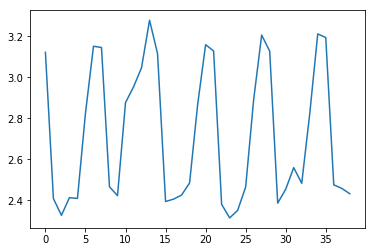

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.049868   
air_0164b9927d20bcc3_2017-04-23              1.471771   
air_0241aa3964b7f861_2017-04-23              2.349276   
air_0328696196e46f18_2017-04-23              2.088550   
air_034a3d5b40d5b1b1_2017-04-23              3.501242   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   6.766873  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.356946  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.477977  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.073197  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.156620

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l3_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')